In [ ]:
runLocation = "googlecolab" 

if runLocation=="googlecolab":
    from google.colab import drive
    drive.mount('/gdrive')
    %cd /gdrive/My\ Drive/Deep\ Classifier\ Trainer

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Deep Classifier Trainer


# **Importing Libraries**


In [ ]:
#Import all Necessary Libraries

import numpy as np
import cv2 as cv
import random
import pickle
import glob
import os
import shutil
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,AveragePooling2D, Flatten
from sklearn.model_selection import train_test_split
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession
!pip install livelossplot
from livelossplot.keras import PlotLossesCallback
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

#**Training Parameters**

In [ ]:
# For Actual Training Parameters
selectedModel = "inceptionv3"; 
neurons = [4096,1024,256]
dataPath = 'traindataskin/' # Folder of Cropped Images

ext = [".jpg",".JPG",".jpeg",".JPEG",".PNG",".png"]
#ext = [".jpeg"]
learningRate = 0.000001;
test_split_size=0.20
validation_split_size=0.20;
maxEpochs = 50; 
useAllSamples = True 
batchSize = 16 # 128; 
fixedStepSize = 32
enableEarlyStop = True;
estype = "val_loss"
patience = 5
layersToUnfreeze = 0

# For data augment parameters
rotAngle = 0
flipHorizontal = False
flipVertical = False


import os
for root, dirs, files in os.walk(dataPath):
    break;

numClasses = len(dirs);


#**For Checking Number of Datasets**

In [ ]:
print('Total Training Dataset:\nAtopic Dermatitis :', len(os.listdir("traindataskin/Atopic Dermatitis")),
      '\nRingworm:', len(os.listdir("traindataskin/Ringworm")),
      '\nPsoriasis:', len(os.listdir("traindataskin/Psoriasis")),
      '\nNummular Dermatitis:', len(os.listdir("traindataskin/Nummular Dermatitis")),
      '\nContact Dermatitis:', len(os.listdir("traindataskin/Contact Dermatitis")),
      '\nNegatives:', len(os.listdir("traindataskin/Negatives")))
print('\nTotal Testing Dataset:\nAtopic Dermatitis:', len(os.listdir("traindataskintest/Atopic Dermatitis")),
      '\nRingworm:', len(os.listdir("traindataskintest/Ringworm")),
      '\nPsoriasis:', len(os.listdir("traindataskintest/Psoriasis")),
      '\nNummular Dermatitis:', len(os.listdir("traindataskintest/Nummular Dermatitis")),
      '\nContact Dermatitis:', len(os.listdir("traindataskintest/Contact Dermatitis")),
      '\nNegatives:', len(os.listdir("traindataskintest/Negatives")))

Total Training Dataset:
Atopic Dermatitis : 375 
Ringworm: 375 
Psoriasis: 375 
Nummular Dermatitis: 375 
Contact Dermatitis: 375 
Negatives: 375

Total Testing Dataset:
Atopic Dermatitis: 100 
Ringworm: 100 
Psoriasis: 100 
Nummular Dermatitis: 100 
Contact Dermatitis: 100 
Negatives: 100


#**For Actual Training**

In [ ]:
    #from tensorflow.keras.preprocessing import image
    if selectedModel == "inceptionv3":
        imgsz = 299; 
        from tensorflow.keras.applications.inception_v3 import preprocess_input
        sourceModel = keras.applications.InceptionV3
    elif selectedModel == "vgg16":
        imgsz = 224; 
        from tensorflow.keras.applications.vgg16 import preprocess_input
        sourceModel = keras.applications.VGG16
    elif selectedModel == "resnet50":
        imgsz = 224;
        from tensorflow.keras.applications.resnet50 import preprocess_input
        sourceModel = keras.applications.ResNet50
    
  
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.models import Model
    from tensorflow.keras import optimizers
    from tensorflow.keras.callbacks import EarlyStopping



    modelName = 'model_' + selectedModel + '.model';
    
    # Import the model and remove the classification layer.
    base_model=sourceModel(weights='imagenet', \
                              include_top=False, \
                              input_shape = (imgsz,imgsz,3)); 


   # To show model architecture
    for i,layer in enumerate(base_model.layers):
        print(i,layer.name,layer.trainable)
        
    # To check the last layer
    x=base_model.output

    addedLayers = 0;
    # if selectedModel == "inceptionv3":

    x = GlobalAveragePooling2D()(x); addedLayers = addedLayers + 1;
    for neuron in neurons:
      if neuron<1:
        x=Dropout(neuron)(x)
      else:
        x=Dense(neuron,activation='relu')(x) 
      addedLayers = addedLayers + 1
    
    preds=Dense(numClasses,activation='softmax')(x); addedLayers = addedLayers + 1;

        


    model=Model(inputs=base_model.input,outputs=preds)

                      
                  
    for layer in model.layers[0:-(addedLayers+layersToUnfreeze)]:
        layer.trainable = False

   # To show model architecture
    for i,layer in enumerate(model.layers):
        print(i,layer.name,layer.trainable)

        
    # Datagen is used for viewing the data images only, prior to preprocessing
    viewing_datagent=ImageDataGenerator(rotation_range=rotAngle,
                                    horizontal_flip=flipHorizontal,
                                    vertical_flip=flipVertical,
                                    validation_split=validation_split_size)

    # Training Datagen is used for training, PreProcessed
    if rotAngle == 0:
        train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                        horizontal_flip=flipHorizontal,
                                        vertical_flip=flipVertical,
                                        validation_split=validation_split_size) 
    else:
        train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input,
                                        rotation_range=rotAngle,
                                        horizontal_flip=flipHorizontal,
                                        vertical_flip=flipVertical,
                                        validation_split=validation_split_size) 

    print("Training Dataset:");
    train_generator=train_datagen.flow_from_directory(dataPath,
                                                    target_size=(imgsz,imgsz),
                                                    color_mode='rgb',
                                                    batch_size=batchSize,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset='training');

    print("Test Validation Dataset:");
    validation_generator=train_datagen.flow_from_directory(dataPath,
                                                    target_size=(imgsz,imgsz),
                                                    color_mode='rgb',
                                                    batch_size=batchSize,
                                                    class_mode='categorical',
                                                    subset='validation',
                                                    shuffle=True);

    print("Sample Viewing Dataset:");
    ## Only for Viewing Unprocessed Images
    view_generator=viewing_datagent.flow_from_directory(dataPath,
                                                    target_size=(imgsz,imgsz),
                                                    color_mode='rgb',
                                                    batch_size=batchSize,
                                                    class_mode='categorical',
                                                    shuffle=True);

   # To show 5 sample images in the training
    x,y = view_generator.next()
    for i in range(0,min([batchSize,5])):
        img = x[i]
        plt.imshow(img.astype(np.uint8))
        plt.show()
        
                                                      


    adamOpt = optimizers.Adam(lr=learningRate);
    model.compile(optimizer=adamOpt, \
                  loss='categorical_crossentropy', \
                  metrics=['accuracy'])
    # Adam is used as optimizer
    # categorical cross entropy is used as loss
    # accuracy is used as evaluation metrics
    if useAllSamples:
        step_size_train=train_generator.n//train_generator.batch_size
    else:
        step_size_train=fixedStepSize

    if enableEarlyStop:
        es = EarlyStopping(monitor=estype,mode='auto', patience=patience)
        
        history = model.fit_generator(generator=train_generator,
                            validation_data = validation_generator,
                          steps_per_epoch=step_size_train,
                          epochs=maxEpochs,
                          callbacks=[PlotLossesCallback(),es]);
    else:
        
        history = model.fit_generator(generator=train_generator,
                            validation_data = validation_generator,
                          steps_per_epoch=step_size_train,
                          epochs=maxEpochs);





    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

  # To save the model
    tf.keras.models.save_model(
        model,
        modelName,
        overwrite=True,
        include_optimizer=True
    )
    model.save("rms_100.h5")
    # To save label names
    labels = (train_generator.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    print(labels);

    fid = open('label_' + selectedModel + '.sav','wb');
    pickle.dump(labels, fid);
    fid.close();


    print("Model successfully trained and saved.");



#**For Testing the Unseen Data**


RANK 1 Accuracy Against Test Data: 66.50 %

CONFUSION MATRIX:


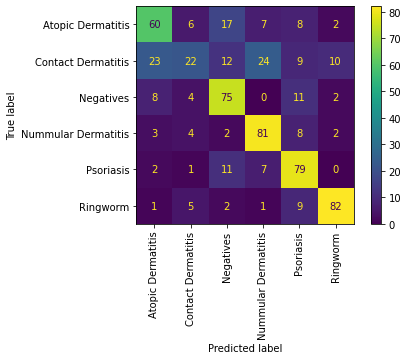


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       100
           1       0.52      0.22      0.31       100
           2       0.63      0.75      0.68       100
           3       0.68      0.81      0.74       100
           4       0.64      0.79      0.71       100
           5       0.84      0.82      0.83       100

    accuracy                           0.67       600
   macro avg       0.65      0.66      0.65       600
weighted avg       0.65      0.67      0.65       600


OUTPUT DISTRIBUTION:
Atopic Dermatitis: 16.17%
Contact Dermatitis: 7.00%
Negatives: 19.83%
Nummular Dermatitis: 20.00%
Psoriasis: 20.67%
Ringworm: 16.33%


In [ ]:
    #from tensorflow.keras.preprocessing import image
    if selectedModel == "inceptionv3":
        imgsz = 299; 
        from tensorflow.keras.applications.inception_v3 import preprocess_input
        sourceModel = keras.applications.InceptionV3
    elif selectedModel == "vgg16":
        imgsz = 224; 
        from tensorflow.keras.applications.vgg16 import preprocess_input
        sourceModel = keras.applications.VGG16
    elif selectedModel == "resnet50":
        imgsz = 224; 
        from tensorflow.keras.applications.resnet50 import preprocess_input
        sourceModel = keras.applications.ResNet50
   
    
    modelName = "model_" + selectedModel + ".model";


    testmodel = tf.keras.models.load_model(
        modelName)
    #    custom_objects=None,
    #    compile=True
    #)

    f = open("label_" + selectedModel + ".sav",'rb');labels = pickle.load(f);f.close();
    labels = list(labels.values());

    X = [];
    y = [];


    for label in labels:

        fileList = []
        for ctrext in range(0,len(ext)):
            
            fileList.extend(glob.glob(dataPath[:-1] + "test" + "/" + label + "/*" + ext[ctrext]))
        
        
        
        for thisFile in fileList:
            
          # CV is used to load the image
            img = cv.imread(thisFile);
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB);
            
          
            img = cv.resize(img,(imgsz,imgsz));
            
            
            img = preprocess_input(img);
            
            X.append(img);
            y.append(labels.index(label));
            
        

    y_preds = testmodel.predict(np.array(X));
    y_pred = [];
    for y_preds_i in y_preds:
        y_pred.append(np.argmax(y_preds_i));
    #y_pred = testmodel.predict(X);

    accuracy = sum(np.equal(y_pred,y)) / len(y) * 100

    print()
    print("RANK 1 Accuracy Against Test Data: " + "{:.2f}".format(accuracy) + " %");


    confmat = confusion_matrix(y, y_pred)

    print()
    print('CONFUSION MATRIX:')
    disp = ConfusionMatrixDisplay(confusion_matrix=confmat,
                              display_labels=labels)
    disp.plot(xticks_rotation='vertical',values_format='')
    plt.show() 

    print();
    print("CLASSIFICATION REPORT:")
    print(classification_report(y, y_pred)) 


    #To show output breakdown
    print()
    print("OUTPUT DISTRIBUTION:")
    outctr = 0;
    total = sum(sum(confmat));
    for col in confmat.T:
        
        totalcol = sum(col)
        
        print(labels[outctr] + ": " + ("%1.2f") % ((totalcol / total) * 100) + "%")
        
        outctr = outctr + 1;


#**For Testing One Image**

In [ ]:
    #from tensorflow.keras.preprocessing import image
    if selectedModel == "inceptionv3":
        imgsz = 299; # 224 resnet and vgg, 299 for inception
        from tensorflow.keras.applications.inception_v3 import preprocess_input
        sourceModel = keras.applications.InceptionV3
    elif selectedModel == "vgg16":
        imgsz = 224; 
        from tensorflow.keras.applications.vgg16 import preprocess_input
        sourceModel = keras.applications.VGG16
    elif selectedModel == "resnet50":
        imgsz = 224; 
        from tensorflow.keras.applications.resnet50 import preprocess_input
        sourceModel = keras.applications.ResNet50
   
        
        

    modelName = "model_" + selectedModel + ".model";


    testmodel = tf.keras.models.load_model(
        modelName)
    #    custom_objects=None,
    #    compile=True
    #)

    f = open("label_" + selectedModel + ".sav",'rb');labels = pickle.load(f);f.close();
    labels = list(labels.values());

    X = [];
    y = [];


    idx = random.randint(0,len(labels)-1)
    label = labels[idx]

    imgFiles = []
    for ctrext in range(0,len(ext)):
        imgFiles.extend(glob.glob(dataPath[:-1] + "test" + "/" + label + "/*" + ext[ctrext]))

    idxFile = random.randint(0,len(imgFiles)-1)

    filepath = imgFiles[idxFile]
    pos1 = filepath.find("/")
    pos2 = filepath.find("/",pos1+1)
    actualClass = filepath[pos1+1:pos2]

    # CV is used to load the image
    img = cv.imread(filepath);
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB);


    plt.title("Input Image")
    plt.imshow(img)
    plt.show()
  
    img = cv.resize(img,(imgsz,imgsz));
    img = preprocess_input(img);

    y_pred = testmodel.predict(np.array([img]));
    print("Image Classified as: ",labels[np.argmax(y_pred[0])])
    print("Actual Class:",actualClass)
    print("Classification Score: ",max(y_pred[0]))
